In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
from os.path import join

sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))
from augmentation import *

In [3]:
#export
def sgd(param, learning_rate, **kwargs):
    param.data -= learning_rate * param.grad
    
def l2_reg(param, weight_decay, **kwargs):
    param.grad += weight_decay * param.data

In [4]:
#export
def compose_inplace(item, fns, **hyper_params):
    for fn in fns:
        fn(item, **hyper_params)

In [5]:
#export
class StatelessOpt():
    # allow different hyper param for each layer
    def __init__(self, params, steppers=None, **hyper_params):
        # list of list of params
        self.params = [params] if isinstance(params, list) else [[params]]
        # set of hyperparams for each param
        self.hypers = [dict(hyper_params) for p in self.params]
        self.steppers = steppers if steppers != None else [sgd]

    def step(self):
        for params, hyper_params in zip(self.params, self.hypers):
            for param in params:
                compose_inplace(param, self.steppers, **hyper_params)              
        
    def zero_grad(self):
        for hps in self.params: 
            for hp in hps:
                hp.zero_grad()

    def __repr__(self):
        return f'(StatelessOpt) steppers: {[stepper.__name__ for stepper in self.steppers]}'

## Renew callbacks

In [6]:
#export
class Recorder(Callback):
    def __init__(self, param_names=['learning_rate']):
        self.parameters = {name: [] for name in param_names}
        
    def before_fit(self):
        self.losses = []
        
    def after_batch(self): 
        if not self.model.training: return
        self.losses.append(self.loss)
        for i, param in enumerate(self.parameters):
            self.parameters[param].append(self.optimizer.hypers[i][param])       

    def plot_losses(self): 
        plt.plot(self.losses)
        plt.ylabel('loss')
        plt.xlabel('batch')
    
    def plot_parameter(self, name):
        plt.plot(self.parameters[name])
        plt.ylabel(' '.join(name.split('_')))
        plt.xlabel('batch')

class LearningRateSearch(Callback):
    def __init__(self, max_iter=1000, min_lr=1e-4, max_lr=1):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = float('inf')
        
    def before_batch(self): 
        if self.model.training:
            position = self.iters_count / self.iters
            learning_rate = self.min_lr * (self.max_lr / self.min_lr) ** position
            for hp in self.optimizer.hypers:
                hp['learning_rate'] = learning_rate
            
    def after_step(self):
        if self.iters_count >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        self.best_loss = min(self.best_loss, self.loss)
            
class ParamScheduler(Callback):
    def __init__(self, param_name, schedule_fn): 
        self.param_name = param_name
        self.schedule_fn = schedule_fn
        
    def set_param(self):
        for hp in self.optimizer.hypers:
            hp[self.param_name] = self.schedule_fn(self.iters_count / self.iters)
            
    def before_batch(self): 
        if self.model.training:
            self.set_param()

# Tests

In [7]:
hyper_params = {'weight_decay':1e-4, 'learning_rate':0.1}

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
optimizer = StatelessOpt(list(model.parameters()), [l2_reg, sgd], **hyper_params)
loss_fn = CrossEntropy()

### Test LearningRateSearch and Recorder

In [8]:
callbacks = [LearningRateSearch(500), Recorder()]
learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
	(DataLoader) 
		(Dataset) x: (50000, 784), y: (50000,)
		(Sampler) total: 50000, batch_size: 64, shuffle: True
	(DataLoader) 
		(Dataset) x: (10000, 784), y: (10000,)
		(Sampler) total: 10000, batch_size: 128, shuffle: False
(Sequential)
	(Layer1) Linear(784, 50)
	(Layer2) ReLU()
	(Layer3) Linear(50, 10)
(CrossEntropy)
(StatelessOpt) steppers: ['l2_reg', 'sgd']
(Callbacks) ['TrainEval', 'LearningRateSearch', 'Recorder']


In [9]:
learner.fit(100)

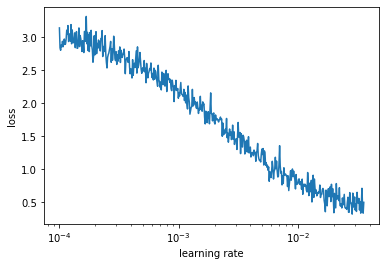

In [10]:
plot_lr_loss(learner.callbacks[2])

### Test ParamScheduler

In [11]:
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.01, 0.5, 0.01))
callbacks = [ParamScheduler('learning_rate', schedule), Recorder()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
	(DataLoader) 
		(Dataset) x: (50000, 784), y: (50000,)
		(Sampler) total: 50000, batch_size: 64, shuffle: True
	(DataLoader) 
		(Dataset) x: (10000, 784), y: (10000,)
		(Sampler) total: 10000, batch_size: 128, shuffle: False
(Sequential)
	(Layer1) Linear(784, 50)
	(Layer2) ReLU()
	(Layer3) Linear(50, 10)
(CrossEntropy)
(StatelessOpt) steppers: ['l2_reg', 'sgd']
(Callbacks) ['TrainEval', 'ParamScheduler', 'Recorder']


In [12]:
learner.fit(3)

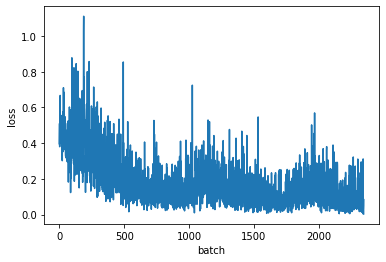

In [13]:
learner.callbacks[2].plot_losses()

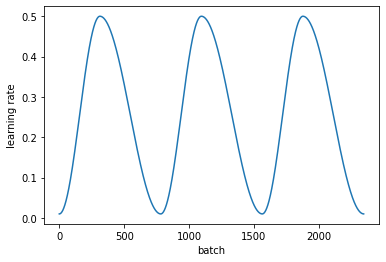

In [14]:
learner.callbacks[2].plot_parameter('learning_rate')